Preprocessing the DATA

In [2]:
#UNZIP the datas of multiple language
import zipfile
import os

# Path to the zip file
zip_file_path = '/content/data (1).zip'

# Directory where you want to extract the files
extract_dir = '/content/'

# Create the extraction directory if it does not exist
os.makedirs(extract_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extraction complete.")

Extraction complete.


In [3]:
import io
import os
import unicodedata
import string
import glob

import torch
import random

# alphabet small + capital letters + " .,;'"
ALL_LETTERS = string.ascii_letters + " .,;'"
N_LETTERS = len(ALL_LETTERS)
print(ALL_LETTERS)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in ALL_LETTERS
    )

def load_data():
    # Build the category_lines dictionary, a list of names per language
    category_lines = {}
    all_categories = []

    def find_files(path):
        return glob.glob(path)

    # Read a file and split into lines
    def read_lines(filename):
        lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
        return [unicode_to_ascii(line) for line in lines]

    for filename in find_files('/content/data/names/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)

        lines = read_lines(filename)
        category_lines[category] = lines
    print("category_lines",category_lines)
    print("all_categories",all_categories)
    return category_lines, all_categories



"""
To represent a single letter, we use a “one-hot vector” of
size <1 x n_letters>. A one-hot vector is filled with 0s
except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.

To make a word we join a bunch of those into a
2D matrix <line_length x 1 x n_letters>.

That extra 1 dimension is because PyTorch assumes
everything is in batches - we’re just using a batch size of 1 here.
"""

# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return ALL_LETTERS.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, N_LETTERS)
    #print("letter to tensor: ",tensor[0][letter_to_index(letter)])
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, N_LETTERS)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    #print("tensor[i][0][letter_to_index(letter)]: ","i: ",tensor)
    return tensor


def random_training_example(category_lines, all_categories):

    def random_choice(a):
        random_idx = random.randint(0, len(a) - 1)
        return a[random_idx]

    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    #print(line)
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor



if __name__ == '__main__':
    print(ALL_LETTERS)
    print(unicode_to_ascii('Ślusàrski'))

    category_lines, all_categories = load_data()
    print(category_lines['Italian'][:5])

    print(letter_to_tensor('J')) # [1, 57]
    print(line_to_tensor('Jones').size()) # [5, 1, 57]

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
Slusarski
category_lines {'German': ['Abbing', 'Abel', 'Abeln', 'Abt', 'Achilles', 'Achterberg', 'Acker', 'Ackermann', 'Adam', 'Adenauer', 'Adler', 'Adlersflugel', 'Aeschelman', 'Albert', 'Albrecht', 'Aleshire', 'Aleshite', 'Althaus', 'Amsel', 'Andres', 'Armbruster', 'Armbruster', 'Artz', 'Aue', 'Auer', 'Augustin', 'Aust', 'Autenburg', 'Auttenberg', 'Baasch', 'Bach', 'Bachmeier', 'Backer', 'Bader', 'Bahr', 'Bambach', 'Bauer', 'Bauers', 'Baum', 'Baumann', 'Baumbach', 'Baumgartner', 'Baumgartner', 'Baumhauer', 'Bayer', 'Beck', 'Becke', 'Beckenbauer', 'Becker', 'Beckert', 'Behrend', 'Behrends', 'Beitel', 'Beltz', 'Benn', 'Berg', 'Berger', 'Bergfalk', 'Beringer', 'Bernat', 'Best', 'Beutel', 'Beyer', 'Beyersdorf', 'Bieber', 'Biermann', 'Bischoffs', 'Blau', 'Blecher', 'Bleier', 'Blumenthal', 'Blumstein', 'Bocker', 'Boehler', 'Boer', 'Boesch', 'Bohler', 'Bohm', 'Bohme', 'Bohmer'

Word Lang Prediction Architecture

In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#from utils import ALL_LETTERS, N_LETTERS
#from utils import load_data, letter_to_tensor, line_to_tensor, random_training_example


class RNN(nn.Module):
    # implement RNN from scratch rather than using nn.RNN
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_tensor, hidden_tensor):
        #print("FORWARD ",input_tensor.view(1,-1).size(),hidden_tensor.size())
        combined = torch.cat((input_tensor.view(1,-1), hidden_tensor), 1)
        #print(combined)
        #combined=combined.view(1,-1)
        #print("combined",combined.size())
        #print("hidden_tensor",hidden_tensor.size())

        hidden = self.i2h(combined)
        output = self.i2o(combined)
        #output=output.view(1,-1)
        output = self.softmax(output)
        #print("output",output.size())

        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

category_lines, all_categories = load_data()
n_categories = len(all_categories)

n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden, n_categories)

# one step
input_tensor = letter_to_tensor('A')
hidden_tensor = rnn.init_hidden()

#output, next_hidden = rnn(input_tensor, hidden_tensor)
#print(output.size())
#print(next_hidden.size())

# whole sequence/name
input_tensor = line_to_tensor('Albert')
hidden_tensor = rnn.init_hidden()
print("ISEZE",input_tensor.size()[0])

print("input_tensor",input_tensor.view(1,6,57).shape)
#print(input_tensor)
print("hidden_tensor",hidden_tensor.shape)
rnn = RNN(N_LETTERS*input_tensor.size()[0], n_hidden, n_categories)
output, next_hidden = rnn(input_tensor, hidden_tensor)
print("OUTPUT",output.size())
print(output)
print(next_hidden.size())

#
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    print(category_idx)
    return all_categories[category_idx]

print(category_from_output(output))

category_lines {'German': ['Abbing', 'Abel', 'Abeln', 'Abt', 'Achilles', 'Achterberg', 'Acker', 'Ackermann', 'Adam', 'Adenauer', 'Adler', 'Adlersflugel', 'Aeschelman', 'Albert', 'Albrecht', 'Aleshire', 'Aleshite', 'Althaus', 'Amsel', 'Andres', 'Armbruster', 'Armbruster', 'Artz', 'Aue', 'Auer', 'Augustin', 'Aust', 'Autenburg', 'Auttenberg', 'Baasch', 'Bach', 'Bachmeier', 'Backer', 'Bader', 'Bahr', 'Bambach', 'Bauer', 'Bauers', 'Baum', 'Baumann', 'Baumbach', 'Baumgartner', 'Baumgartner', 'Baumhauer', 'Bayer', 'Beck', 'Becke', 'Beckenbauer', 'Becker', 'Beckert', 'Behrend', 'Behrends', 'Beitel', 'Beltz', 'Benn', 'Berg', 'Berger', 'Bergfalk', 'Beringer', 'Bernat', 'Best', 'Beutel', 'Beyer', 'Beyersdorf', 'Bieber', 'Biermann', 'Bischoffs', 'Blau', 'Blecher', 'Bleier', 'Blumenthal', 'Blumstein', 'Bocker', 'Boehler', 'Boer', 'Boesch', 'Bohler', 'Bohm', 'Bohme', 'Bohmer', 'Bohn', 'Borchard', 'Bosch', 'Bosch', 'Bottcher', 'Brahms', 'Brand', 'Brandt', 'Brant', 'Brauer', 'Braun', 'Braune', 'Breine

Word Lang Training and Prediction

14
1000 20.0 2.9103 Gorski / Scottish WRONG (Polish)
7
2000 40.0 2.7723 Oh  / Korean CORRECT
9
3000 60.0 2.8466 Kavanagh / French WRONG (Irish)
7
4000 80.0 2.9802 Lyon / Korean WRONG (French)
0
5000 100.0 2.9789 Moon / German WRONG (Korean)


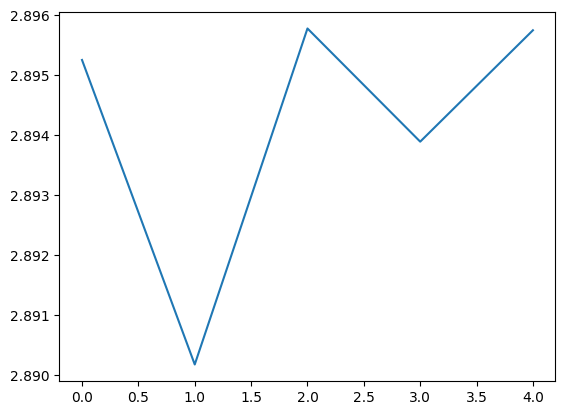

In [9]:
criterion = nn.NLLLoss()
learning_rate = 0.05
#print(rnn.parameters())
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

def train(line_tensor, category_tensor):
    rnn = RNN(N_LETTERS*line_tensor.size()[0], n_hidden, n_categories)
    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
        #output, hidden = rnn(line_tensor[i], hidden)->for one char
        output, hidden = rnn(line_tensor, hidden) #for the word

    loss = criterion(output, category_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output, loss.item()

current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 1000
n_iters = 5000
for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)
    #print(line_tensor[0:6])
    output, loss = train(line_tensor[0:6], category_tensor)
    current_loss += loss

    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0

    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i+1} {(i+1)/n_iters*100} {loss:.4f} {line} / {guess} {correct}")


plt.figure()
plt.plot(all_losses)
plt.show()


In [11]:
def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        #for i in range(line_tensor.size()[0]):

        rnn = RNN(N_LETTERS*line_tensor.size()[0], n_hidden, n_categories)
        hidden = rnn.init_hidden()
        output, hidden = rnn(line_tensor, hidden)

        guess = category_from_output(output)
        print(guess)

while True:
    sentence = input("Input:")
    if sentence == "quit":
        break

    predict(sentence)

Input:Arvanitoyannis

> Arvanitoyannis
3
Vietnamese
Input:Chellos

> Chellos
0
German
Input:quit


Single Character Lang Prediction Architecture

In [15]:

#code to predict single char
class RNN(nn.Module):
    # implement RNN from scratch rather than using nn.RNN
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_tensor, hidden_tensor):
        #print("FORWARD ",input_tensor.size(),hidden_tensor.size())
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        #print("FORWARD: ",combined.size())
        #print(combined.size())
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        #print("output",output.size())
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

category_lines, all_categories = load_data()
n_categories = len(all_categories)
#print(N_LETTERS)

n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden, n_categories)

# one step
input_tensor = letter_to_tensor('A')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor, hidden_tensor)
#print(output.size())
#print(next_hidden.size())

# whole sequence/name
input_tensor = line_to_tensor('Albert')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor[0], hidden_tensor)
#print(output.size())
#print(next_hidden.size())

#
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    print(category_idx)
    return all_categories[category_idx]

print(category_from_output(output))

category_lines {'German': ['Abbing', 'Abel', 'Abeln', 'Abt', 'Achilles', 'Achterberg', 'Acker', 'Ackermann', 'Adam', 'Adenauer', 'Adler', 'Adlersflugel', 'Aeschelman', 'Albert', 'Albrecht', 'Aleshire', 'Aleshite', 'Althaus', 'Amsel', 'Andres', 'Armbruster', 'Armbruster', 'Artz', 'Aue', 'Auer', 'Augustin', 'Aust', 'Autenburg', 'Auttenberg', 'Baasch', 'Bach', 'Bachmeier', 'Backer', 'Bader', 'Bahr', 'Bambach', 'Bauer', 'Bauers', 'Baum', 'Baumann', 'Baumbach', 'Baumgartner', 'Baumgartner', 'Baumhauer', 'Bayer', 'Beck', 'Becke', 'Beckenbauer', 'Becker', 'Beckert', 'Behrend', 'Behrends', 'Beitel', 'Beltz', 'Benn', 'Berg', 'Berger', 'Bergfalk', 'Beringer', 'Bernat', 'Best', 'Beutel', 'Beyer', 'Beyersdorf', 'Bieber', 'Biermann', 'Bischoffs', 'Blau', 'Blecher', 'Bleier', 'Blumenthal', 'Blumstein', 'Bocker', 'Boehler', 'Boer', 'Boesch', 'Bohler', 'Bohm', 'Bohme', 'Bohmer', 'Bohn', 'Borchard', 'Bosch', 'Bosch', 'Bottcher', 'Brahms', 'Brand', 'Brandt', 'Brant', 'Brauer', 'Braun', 'Braune', 'Breine

Single Character Lang Training and Prediction

5
500 10.0 2.8607 Favre / Irish WRONG (French)
4
1000 20.0 2.5902 Basurto / Russian WRONG (Portuguese)
3
1500 30.0 3.2886 Said / Vietnamese WRONG (Arabic)
1
2000 40.0 1.7479 Fonseca / Portuguese CORRECT
6
2500 50.0 3.4069 O'Hara / Japanese WRONG (Irish)
0
3000 60.0 nan Dinapoli / German WRONG (Italian)
0
3500 70.0 nan Nowak / German WRONG (Polish)
0
4000 80.0 nan Viney / German WRONG (English)
0
4500 90.0 nan Gravari / German WRONG (Greek)
0
5000 100.0 nan Thai / German WRONG (Vietnamese)


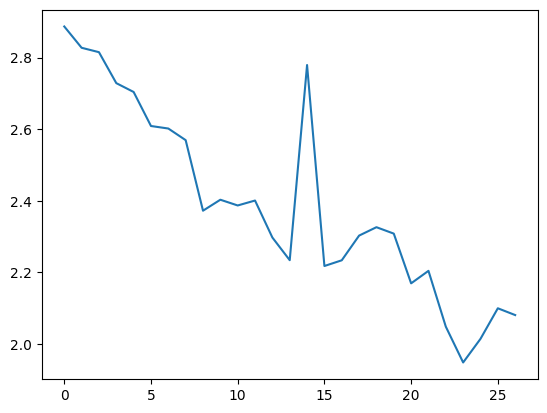

In [16]:

criterion = nn.NLLLoss()
learning_rate = 0.05
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

def train(line_tensor, category_tensor):
    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output, loss.item()

current_loss = 0
all_losses = []
plot_steps, print_steps = 100, 500
n_iters = 5000  #increase no. of iteration for better accuracy
for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)

    output, loss = train(line_tensor, category_tensor)
    current_loss += loss

    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0

    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i+1} {(i+1)/n_iters*100} {loss:.4f} {line} / {guess} {correct}")


plt.figure()
plt.plot(all_losses)
plt.show()



In [18]:
def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)

        hidden = rnn.init_hidden()

        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)

        guess = category_from_output(output)
        print(guess)


while True:
    sentence = input("Input:")
    if sentence == "quit":
        break

    predict(sentence)

Input:H

> H
0
German
Input:J

> J
0
German
Input:quit
